## Aprendizagem Automática - Projeto

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models and selection methods
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
# Linear regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.preprocessing import LabelBinarizer

In [74]:
# Funcoes auxiliares

def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    

#Devolve uma lista com quantos elementos há seguidos entre valores de NaN. p.e: [1,nan,2,3,nan,nan,2,nan,2,3,4] -> [1,2,1,3]
def count_not_nan(serie):
    conta=0
    lista_seguida=[]
    for i in range(len(serie)):
        if serie[i]==1:
            conta+=1
        else:
            if conta!=0:
                lista_seguida.append(conta)
                conta=0
            else:
                conta=0
                
        if i==len(serie)-1 and conta!=0:
            lista_seguida.append(conta)
    return lista_seguida

#Função que lida com os nan nas df. Se o país não tiver nenhum dado -> drop. Se o país não tiver pelo menos 5 dados entre 2000
# e 2016 -> drop. O resto fica

def drop_nan(df,lag):
    pais_nan=[]
    for pais in df["Country Name"].index:
        nan_val=list(pd.DataFrame(df.iloc[pais][4:]).count(axis=1)) #ver se os valores são nan
        if sum(nan_val)==0: #se for tudo nan
            pais_nan.append(pais)
        elif max(count_not_nan(nan_val))<=lag: #Se entre 2000 e 2016 não houver mais do que lag valores seguidos, drop
            pais_nan.append(pais)

    df=df.drop(pais_nan, axis=0)
    df = df.reset_index(drop=True)
    return df

#Função que escolha o dataframe até um certo ano apenas, que remove os países que contenham nan nesse intervalo de tempo

def indexing(dataf, ano_i):
    X_list=dataf.drop(columns=dataf.iloc[:,[1,2,3]]+dataf.loc[:,[str(i) for i in range(1960,ano_i)]])
    X_list=X_list.T
    X_list=X_list.rename(columns=X_list.iloc[0]).drop(X_list.index[0])
    return X_list

#Cria um DataFrame com os dados de um país e respetivos lags

def lags(df, lag, país):
    new_df=pd.DataFrame()
    new_df["dados"]=df[país]
    colunas = [str(i) + "lag" for i in range(1,lag+1)]

    for i,k in enumerate(colunas):
        new_df[k] = new_df["dados"].shift(+i+1)
    new_df=new_df.dropna()
    return new_df

#Função que cria o dataset necessário para as timeseries. As time series são todas unidas numa só coluna e os países respetivos
# a essa série temporal recebem um 1. Também concatena os lags no início da df.

def time_series(df, lag):
    binario = LabelBinarizer().fit(df.columns)
    df_final= pd.DataFrame()
    for pais in df.columns:
        pais_bin=pd.DataFrame(data=list(binario.transform([pais]))*len(df[pais]),
                             columns=binario.classes_,
                             index=df.index)
        #Agora juntamos os lags e os dados respetivos
        df_mid=pd.DataFrame()
        df_mid=pd.concat((df_mid,lags(df, lag, pais),pais_bin),axis=1).dropna()

        #Finalmente, concatenamos tudo numa só DataFrame
        df_final = pd.concat((df_final, df_mid), sort=True)
        df_fina=df_final.dropna()
    return df_final

Importação dos datasets

In [114]:
# Dados 1960-2016
fertility = pd.read_csv("fertility_rate.csv")
population= pd.read_csv("country_population.csv")
expectancy = pd.read_csv("life_expectancy.csv")

fertility=drop_nan(fertility,4)
population=drop_nan(population,4)
expectancy=drop_nan(expectancy,4)

# Dados 1960-2020
fertility_2020 = pd.read_csv("fertility_2020.csv")
population_2020 = pd.read_csv("population_2020.csv")
expectancy_2020 = pd.read_csv("life_2020.csv")

#Criar os data frames

X_fert=indexing(fertility, 1960)
X_pop=indexing(population, 1960)
X_exp=indexing(expectancy, 1960)

fert_2020 = indexing(fertility_2020, 1960)
pop_2020 = indexing(population_2020, 1960)
exp_2020 = indexing(expectancy_2020, 1960)



Escolher a sample de 10 países aleatórios

In [93]:
sample = list(fertility["Country Name"].sample(n=10, random_state=483))
print(sample)

['Lesotho', 'North America', 'New Zealand', 'Singapore', 'Europe & Central Asia', 'Qatar', 'Uzbekistan', 'Estonia', 'Angola', 'Japan']


IGNORAR ESTA PARTE COM O GRAFICO

In [283]:
df=lags(X_fert,5, 'Afghanistan')
dfc=df.to_numpy()
X_train=np.delete(dfc,0,1)
y_train=dfc[:,0]
#print(X_train.shape)
X_train_fin,y_train_fin, X_test, y_test= X_train[:35], y_train[:35], X_train[-17:], y_train[-17:]
#print(y_train_fin, y_test)
lin_model=LinearRegression()
lin_model.fit(X_train_fin,y_train_fin)
pred=lin_model.predict(X_test)
#print(X_test)
#df

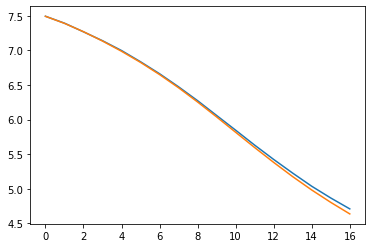

The RVE is:  0.9994022090438207
The rmse is:  0.03450009002803316
The Correlation Score is is: 1.0000 (p-value=1.595293e-35)

The Maximum Error is is:  0.07286944579075971
The Mean Absolute Error is:  0.02621630869165384


In [284]:
plt.plot(pred, label="pred")
plt.plot(y_test,label="true")
plt.show()
printRegStatistics(y_test, pred)

In [60]:
lin_model.predict([[4.635, 4.802, 4.981, 5.174, 5.38]])

array([4.55583905])

O CODIGO VOLTA AQUI

Vamos continuar a transformar o nosso dataset, de forma a que fiquem todas as séries temporais numa só coluna, a referência respetiva de que país se refere a série temporal e os respetivos lags para cada valor. 

In [115]:
#Versão final dos datasets
X_pop_fin=time_series(X_pop,4)
X_fert_fin=time_series(X_fert,4)
X_exp_fin=time_series(X_exp,4)

X_pop_fin

,1lag,2lag,3lag,4lag,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,...,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe,dados
1964,56695.0,56225.0,55438.0,54211.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57032.0
1965,57032.0,56695.0,56225.0,55438.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57360.0
1966,57360.0,57032.0,56695.0,56225.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57715.0
1967,57715.0,57360.0,57032.0,56695.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58055.0
1968,58055.0,57715.0,57360.0,57032.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,14386649.0,14086317.0,13810599.0,13558469.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,14710826.0
2013,14710826.0,14386649.0,14086317.0,13810599.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15054506.0
2014,15054506.0,14710826.0,14386649.0,14086317.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15411675.0
2015,15411675.0,15054506.0,14710826.0,14386649.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15777451.0


In [91]:
X_pop_fin.to_csv("dfpop.csv")
X_fert_fin.to_csv("dffert.csv")
X_exp_fin.to_csv("dfexp.csv")

Com isto feito, podemos passar ao treino dos modelos

In [104]:
# Função para criar um dataframe X para um dado dataset, pais e ano
def createX(dataset : pd.DataFrame, country : str, year : int, lag) -> pd.DataFrame:
    previousYearCountryData = dataset.loc[(dataset[country] == 1) & (dataset.index.get_level_values(0) == str(year - 1))]
    newX = previousYearCountryData.copy()
    newX.index = [str(year)]
    for i in range(lag,2,-1):
        newX.at[str(year), str(i)+"lag"] = newX.at[str(year),str(i-1)+"lag"]
    newX.at[str(year), "1lag"] = newX.at[str(year),"dados"]
    newX.drop(["dados"], axis=1, inplace=True)
    return newX

# Função para prever dados novos para um dado dataset ano e pais a partir do modelo treinado dado
def predictAndCalculateDelta(model, dataset : pd.DataFrame, country : str, year : int, lag) -> float:
    previousYearCountryData = dataset.loc[(dataset[country] == 1) & (dataset.index.get_level_values(0) == str(year - 1))]
    newX = createX(dataset, country, year, lag)
    x = model.predict(newX)
    x_previous = previousYearCountryData.at[str(year-1),"dados"]
    delta = x - x_previous
    return x[0], delta[0]

# Imprime os resultados de forma agradavel
def printResults(prediction, real, country : str, year : int):
    pred_x, pred_delta = prediction
    real_x, real_delta = real
    abs_error, rel_error = calculateErrors(real_x, pred_x)
    print("Country: %s" % country)
    print("Year: %d" % year)
    print("Predictions".ljust(30) + "Real")
    print(("Data: %.2f" % pred_x).ljust(30) + ("%.2f" % real_x))
    print(("Delta: %.2f" % pred_delta).ljust(30) + ("%.2f" % real_delta))
    print("Error:   Absolute = %.2f    Relative = %.5f\n" % (abs_error, rel_error))

# Vai buscar o valor para um dado ano e pais e calcula o delta
def determineRealResults(dataset : pd.DataFrame, country : str, year : int):
    real_data = dataset.at[str(year), country]
    previous_year_data = dataset.at[str(year-1), country]
    delta = real_data - previous_year_data
    return real_data, delta

# Erro relativo e absoluto
def calculateErrors(real, pred):
    abs_error = abs(pred - real)
    relative_error = abs_error / real
    return abs_error, relative_error

##### Teste para population

In [117]:
y_pop = X_pop_fin["dados"]
X_pop = X_pop_fin[list(X_pop_fin.columns)[:-1]] # Remover dados que é a ultima coluna

reg = DecisionTreeRegressor()
reg.fit(X_pop, y_pop)

DecisionTreeRegressor()

In [118]:
random_country_pop_stats = []
for country in sample[:5]:
    pred = predictAndCalculateDelta(reg, X_pop_fin, country, 2017, 4)
    real = determineRealResults(pop_2020, country, 2017)
    random_country_pop_stats.append((country, pred, real))
    printResults(pred, real, country, 2017)

Country: Lesotho
Year: 2017
Predictions                   Real
Data: 2229800.00              2170617.00
Delta: 25979.00               26745.00
Error:   Absolute = 59183.00    Relative = 0.02727

Country: North America
Year: 2017
Predictions                   Real
Data: 369246309.00            361731237.00
Delta: 9788816.00             2485441.00
Error:   Absolute = 7515072.00    Relative = 0.02078

Country: New Zealand
Year: 2017
Predictions                   Real
Data: 4798509.00              4813600.00
Delta: 105309.00              99500.00
Error:   Absolute = 15091.00    Relative = 0.00314

Country: Singapore
Year: 2017
Predictions                   Real
Data: 5814006.00              5612253.00
Delta: 206723.00              4970.00
Error:   Absolute = 201753.00    Relative = 0.03595

Country: Europe & Central Asia
Year: 2017
Predictions                   Real
Data: 919956023.00            915855416.00
Delta: 8108745.00             3480711.00
Error:   Absolute = 4100607.00    Relativ

In [119]:
for country in sample[5:]:
    pred = predictAndCalculateDelta(reg, X_pop_fin, country, 2017, 4)
    real = determineRealResults(pop_2020, country, 2017)
    random_country_pop_stats.append((country, pred, real))
    printResults(pred, real, country, 2017)

Country: Qatar
Year: 2017
Predictions                   Real
Data: 2667470.00              2711755.00
Delta: 97666.00               116589.00
Error:   Absolute = 44285.00    Relative = 0.01633

Country: Uzbekistan
Year: 2017
Predictions                   Real
Data: 32943584.00             32388600.00
Delta: 1095684.00             540700.00
Error:   Absolute = 554984.00    Relative = 0.01714

Country: Estonia
Year: 2017
Predictions                   Real
Data: 1315790.00              1317384.00
Delta: 0.00                   1594.00
Error:   Absolute = 1594.00    Relative = 0.00121

Country: Angola
Year: 2017
Predictions                   Real
Data: 29435944.00             30208628.00
Delta: 622481.00              1053882.00
Error:   Absolute = 772684.00    Relative = 0.02558

Country: Japan
Year: 2017
Predictions                   Real
Data: 126994511.00            126972000.00
Delta: 0.00                   -104000.00
Error:   Absolute = 22511.00    Relative = 0.00018



In [120]:
random_country_pop_stats

[('Lesotho', (2229800.0, 25979.0), (2170617.0, 26745.0)),
 ('North America', (369246309.0, 9788816.0), (361731237.0, 2485441.0)),
 ('New Zealand', (4798509.0, 105309.0), (4813600.0, 99500.0)),
 ('Singapore', (5814006.0, 206723.0), (5612253.0, 4970.0)),
 ('Europe & Central Asia', (919956023.0, 8108745.0), (915855416.0, 3480711.0)),
 ('Qatar', (2667470.0, 97666.0), (2711755.0, 116589.0)),
 ('Uzbekistan', (32943584.0, 1095684.0), (32388600.0, 540700.0)),
 ('Estonia', (1315790.0, 0.0), (1317384.0, 1594.0)),
 ('Angola', (29435944.0, 622481.0), (30208628.0, 1053882.0)),
 ('Japan', (126994511.0, 0.0), (126972000.0, -104000.0))]

Vamos passar à validação do modelo. Vamos separar o nosso dataset numa certa percentagem para training e outra para testing. Para tal, temos de voltar ao dataset e dividi-lo devidamente, fazendo uma divisão de 70% para training e 30% para testing.

In [111]:
#Cria os dataframes para o treino e teste

def set_train_test(df,lag): 
    train_set=pd.DataFrame()
    test_set=pd.DataFrame()
    paises=list(df.columns[lag:-1])
    
    for pais in paises:
        dados_pais=df[df[str(pais)]==1]
        pais_train= dados_pais[:int(0.7*(len(dados_pais.index)))] #Training set com 70% dos dados
        pais_test=dados_pais[int(0.7*(len(dados_pais.index))):] #Test de 30%
        
        train_set=pd.concat((train_set,pais_train))
        test_set=pd.concat((test_set, pais_test))
   
    return train_set, test_set
    

def valid_pais(df, df_train, df_test, país, lag):
    
    X_train, y_train = df_train[list(df_train.columns)[:-1]], df_train["dados"]
    X_test, y_test = df_test[list(df_test.columns)[:-1]], df_test["dados"]

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    previsoes=[]
    anos=[int(i) for i in list(df_test[df_test[país]==1].index)] #lista de anos que vaõ ser testados
    for ano in anos:
        pred = predictAndCalculateDelta(reg, df, país, ano, lag)     
        previsoes.append(pred[0])
        
    y_test_país=df_test[df_test[país]==1]["dados"]
    return anos, previsoes, y_test_país

In [121]:
#Façamos os nossos datasets para validação.
X_pop_train, X_pop_test= set_train_test(X_pop_fin,4)
X_fert_train, X_fert_test= set_train_test(X_fert_fin,4)
X_exp_train, X_exp_test= set_train_test(X_exp_fin,4)

#E agora validamos os modelos, utilizando os países do nosso sample
#Só um teste
anos_aruba, prev_aruba, reais_aruba=valid_pais(X_pop_fin, X_pop_train, X_pop_test, 'Portugal', 3)


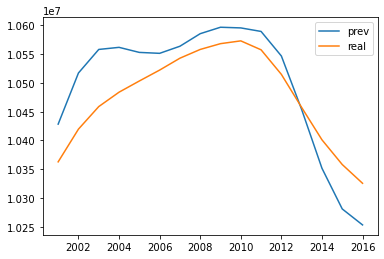

The RVE is:  0.5732759445389768
The rmse is:  56634.138306131084
The Correlation Score is is: 0.9010 (p-value=1.913688e-06)

The Maximum Error is is:  99364.1538184639
The Mean Absolute Error is:  49078.29789254768


In [122]:
plt.plot(anos_aruba, prev_aruba)
plt.plot(anos_aruba, reais_aruba)
plt.legend(["prev","real"])
plt.show()
printRegStatistics(reais_aruba, prev_aruba)